# Work by Tal Halpern

### We will demonstrate the ability of a deep learning model to estimate the rotation angle of an image. The input to the network are the original and rotated images and the output the estimated rotation. We will use a network similar to the one used in examples for image recognition (like https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py). Instead of a softmax layer  we will have one output neuron with tanh activation. The angle range is normalised such that -180 deg transferred to -1 and 180 to 1. We will also use a specific loss function to accommodate the cyclic nature of the rotation (if the image was rotated by 10 deg and the prediction was -20 the correct dist is 30 deg not 330 deg). The loss function is taken from https://github.com/d4nst/RotNet/blob/master/utils.py

#### Importing stuff:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

import torch
from torch.autograd import Variable
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader 
from torch import normal, nn, optim
import torch.nn.functional as F
from torch import cat

from torchvision import datasets, transforms
from torchvision.utils import save_image
import pickle
from scipy.ndimage.interpolation import rotate


#### Helper funcs:

In [2]:
def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]
def plot_rotated_images(x_train,x_train_rotated,shift_angles,pair_num_to_use=1):
    counter=1
    fig = plt.figure()
    for term in range(pair_num_to_use):
        img_id_to_use=np.random.randint(low=0,high=shift_angles.shape[0])
        ax=fig.add_subplot(pair_num_to_use,2,counter)
        img_temp=np.squeeze(x_train[img_id_to_use])
        plt.imshow(img_temp,cmap='gray')
        ax.set_title("no rotation")
        
        counter+=1
        ax=fig.add_subplot(pair_num_to_use,2,counter)
        img_temp=np.squeeze(x_train_rotated[img_id_to_use])
        plt.imshow(img_temp,cmap='gray')
        ax.set_title("rotation angle of {0:.2f}".format(shift_angles[img_id_to_use]*180))
        counter+=1
    fig.tight_layout()
def rotate_images(x_train,shift_angles):
    x_train_rotated=np.zeros(x_train.shape)
    for term in range(x_train.shape[0]):
        img_temp=x_train[term]
        angle_temp=shift_angles[term]*359
        img_rotated=rotate(img_temp,angle_temp,reshape=False)
        x_train_rotated[term]=img_rotated
    return x_train_rotated
def get_train_validation(x_train,x_train_rotated,shift_angles,validation_size):
    total_sample_num=x_train_rotated.shape[0]
    train_size=total_sample_num-validation_size
    rand_vals=np.random.uniform(size=(total_sample_num))
    new_loc=np.argsort(rand_vals)
    x_train_rotated=x_train_rotated[new_loc]
    x_train=x_train[new_loc]
    shift_angles=shift_angles[new_loc]
    
    x_validation=x_train[-validation_size:]
    x_validation_rotated=x_train_rotated[-validation_size:]
    shift_angles_validation=shift_angles[-validation_size:]
   
    x_train=x_train[:train_size]
    x_train_rotated=x_train_rotated[:train_size]
    shift_angles=shift_angles[:train_size]
   
    out_dict={}
    out_dict["x_train"]=x_train
    out_dict["x_train_rotated"]=x_train_rotated
    out_dict["shift_angles"]=shift_angles
   
    out_dict["x_validation"]=x_validation
    out_dict["x_validation_rotated"]=x_validation_rotated
    out_dict["shift_angles_validation"]=shift_angles_validation
 
    return out_dict

def duplicate_data(x_train_original,repetition_num):
    x_train=x_train_original.copy()
    for term in range(repetition_num-1):
        x_train=np.concatenate((x_train,x_train_original),axis=0)
    return x_train
def get_stats(group):
    return {'median_err': group.min(), 'max_err': group.max()\
            , 'count': group.count(), 'mean_err': group.mean()\
            , "std_err": group.std()}
        
    
    

#### Network definitions and network utility funcs: 

In [3]:
import torch.nn as nn

class rotation_predict_net(nn.Module):
    def __init__(self):
        super(rotation_predict_net, self).__init__()
        self.cnn_1 = nn.Conv2d(2, 32, 3,padding=1)
        self.activation_2=nn.ReLU()
        self.cnn_3=nn.Conv2d(32, 64, kernel_size=3,padding=1)
        self.activation_4=nn.ReLU()
        self.pool_5=nn.MaxPool2d(2, stride=2)
        self.dropout_6=torch.nn.Dropout(p=0.25)
        self.fc_7=nn.Linear(64 * 14 * 14, 128)
        self.activation_8=nn.ReLU()
        self.dropout_9=torch.nn.Dropout(p=0.5)
        self.fc_10=nn.Linear(128, 50)
        self.activation_11=nn.ReLU()
        self.fc_12=nn.Linear(50,1)
        #self.activation_13=nn.Hardtanh(min_val=0,max_val=1)
        self.activation_13=nn.Tanh()
    def forward(self, x):
        x=self.cnn_1(x)
        x=self.activation_2(x)
        x=self.cnn_3(x)
        x=self.activation_4(x)
        x=self.pool_5(x)
        x=self.dropout_6(x)
        x=x.view(x.size()[0], -1)
        x=self.fc_7(x)
        x=self.activation_8(x)
        x=self.dropout_9(x)
        x=self.fc_10(x)
        x=self.activation_11(x)
        x=self.fc_12(x)
        out=self.activation_13(x)
        return out

    
class SiameseNetwork_tal(nn.Module):
    def __init__(self):
        super(SiameseNetwork_tal, self).__init__()
        self.cnn_1 = nn.Conv2d(1, 32, 3,padding=1)
        self.activation_2=nn.ReLU()
        self.cnn_3=nn.Conv2d(32, 64, kernel_size=3,padding=1)
        self.activation_4=nn.ReLU()
        self.pool_5=nn.MaxPool2d(2, stride=2)
        self.dropout_6=torch.nn.Dropout(p=0.25)
        self.fc_7=nn.Linear(64 * 14 * 14, 128)
        self.activation_8=nn.ReLU()
        self.fc_9=nn.Linear(128*2, 200)
        self.activation_10=nn.ReLU()
        self.fc_11=nn.Linear(200, 50)
        self.activation_12=nn.ReLU()
        self.fc_13=nn.Linear(50,1)
        #self.activation_14=nn.Hardtanh(min_val=0,max_val=1)
        self.activation_14=nn.Tanh()


       

    def forward_once(self, data):
        
        x=self.cnn_1(data)
        x=self.activation_2(x)
        x=self.cnn_3(x)
        x=self.activation_4(x)
        x=self.pool_5(x)
        x=self.dropout_6(x)
        x=x.view(x.size()[0], -1)
        x=self.fc_7(x)
        x=self.activation_8(x)
        
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        merged=cat((output1,output2),1)
        
        x=self.fc_9(merged)
        x=self.activation_10(x)
        x=self.fc_11(x)
        x=self.activation_12(x)
        x=self.fc_13(x)
        out=self.activation_14(x)
        
        return out

def angle_loss_abs(angles_original,angles_predicted,return_type="sum"):
    angles_original=torch.mul(angles_original,180)
    #print(angles_original.size())
    angles_predicted=torch.mul(angles_predicted,180)
    #print(angles_predicted.size())
    #diff=torch.sub(angles_original - angles_predicted)
    err_vec=180 - torch.abs(torch.abs(angles_original - angles_predicted) - 180)
    #print(err_vec.size())

    if return_type=="sum":
        return torch.sum(err_vec)
    elif return_type=="mean":
        return torch.mean(err_vec)
    elif return_type=="full":
        return err_vec
    
def get_prediction(data,data_rotated,model):
    model.eval()
    data=Variable(data)
    data_rotated=Variable(data_rotated)
    data=data.unsqueeze(1)
    data_rotated=data_rotated.unsqueeze(1)
    merged=cat((data,data_rotated),1)
    shift_angles_predicted = model(merged)
    return shift_angles_predicted

def get_prediction_Siamese(data,data_rotated,model):
    model.eval()
    data=Variable(data)
    data_rotated=Variable(data_rotated)
    data=data.unsqueeze(1)
    data_rotated=data_rotated.unsqueeze(1)
    shift_angles_predicted = model(data,data_rotated)
    return shift_angles_predicted

def early_stopping(previos_loss,loss,tics,allowed_tics=4,improvment_needed=0.05):
    if loss.data.numpy()>previos_loss:
        tics+=1
        print("no significat validation improvment number {}".format(tics))
        if tics>allowed_tics:
            stuck=1
            tics=0
        else:
            stuck=0
    else:
        delta_loss=previos_loss-loss.data.numpy()
        if delta_loss>=improvment_needed:
            previos_loss=loss.data.numpy()
            tics=0
            stuck=0
        else:
            tics+=1
            print("no significat validation improvment number {}".format(tics))
            if tics>allowed_tics:
                stuck=1
                tics=0
            else:
                stuck=0
    return previos_loss,tics,stuck

def plot_train_err(loss_list,validation_list,batch_idx_list):
    validation_arr=np.array(validation_list)
    loss_arr=np.array(loss_list)
    batch_arr=np.array(batch_idx_list)
    plt.plot(batch_arr,validation_arr,"r",label='validation_data')
    plt.plot(batch_arr,loss_arr,"b",label='train_data')
    plt.legend()
    plt.xlabel("mini batch")
    plt.ylabel("err")
    plt.title("train err plot")
    plt.show()
            
            
        
    
        
    


    

#### importing data, reshaping from a row representation to a square image of size 28x28. Images are normalised to range 0-1 (for simplicity no mean subtraction).  Instead of doing multiple epochs over the data we will use the fact that the data is actually generated by us. We will train the network for one epoch but on a duplicated dataset with random rotations. Actual run results are best for one epoch of original dataset or duplicated once

In [17]:
x_train_original, _, _, _ = load()
print("original train size: {}".format(x_train_original.shape))
repetition_num=2
x_train=duplicate_data(x_train_original,repetition_num)
print("after duplication, train size is: {}".format(x_train.shape))
x_train=x_train.reshape((x_train.shape[0],28,28))
print("reshape, train size is: {}".format(x_train.shape))
x_train = x_train.astype('float32') / 255.
print("images are normalized, train max val: {}, train min val: {}".format(x_train.max(),x_train.min()))


original train size: (60000, 784)
after duplication, train size is: (120000, 784)
reshape, train size is: (120000, 28, 28)
images are normalized, train max val: 1.0, train min val: 0.0


#### now we will draw rotation angles and generate the rotated images. Angle range is normelized so that [-180,180]--> [-1,1]

In [18]:
shift_angles=np.random.normal(0,5,size=(x_train.shape[0]))
shift_angles=shift_angles/180
print("max anti clockwise shift (posotive): {:.2f}, max clockwise shift (negative): {:.2f}"\
      .format(shift_angles.max()*180,shift_angles.min()*180))
x_train_rotated=rotate_images(x_train,shift_angles)

max anti clockwise shift (posotive): 20.29, max clockwise shift (negative): -21.45


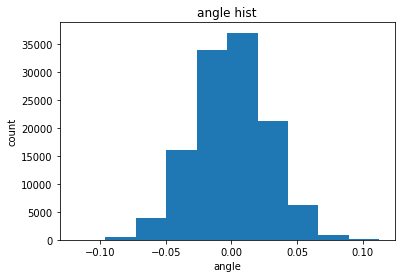

In [19]:
ax=plt.hist(shift_angles)
plt.title("angle hist")
plt.xlabel("angle")
plt.ylabel("count")
plt.show()

#### lets generate a validation set to monitor our training. MNIST comes mixed but we will mix it again and then grab the specified size of validation 

In [20]:
validation_size=5000
out_dict=get_train_validation(x_train,x_train_rotated,shift_angles,validation_size)
x_train=out_dict["x_train"]
x_train_rotated=out_dict["x_train_rotated"]
shift_angles=out_dict["shift_angles"]
x_validation=out_dict["x_validation"]
x_validation_rotated=out_dict["x_validation_rotated"]
shift_angles_validation=out_dict["shift_angles_validation"]
print("new size of train is: {}, validation size is: {}".format(x_train.shape[0],x_validation.shape[0]))

new size of train is: 115000, validation size is: 5000


#### lets see the train data

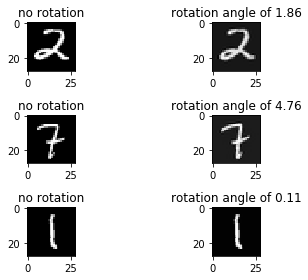

In [21]:
plot_rotated_images(x_train,x_train_rotated,shift_angles,pair_num_to_use=3)


#### and the validation data

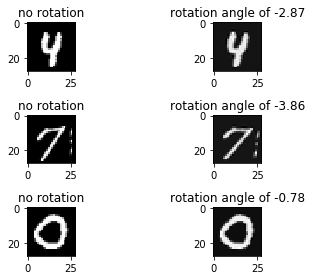

In [22]:
plot_rotated_images(x_validation,x_validation_rotated,shift_angles_validation,pair_num_to_use=3)

#### last part, turn numpy into torch and build a DataLoader

In [23]:
train_data_tn=torch.from_numpy(x_train).float()
train_data_rotated_tn=torch.from_numpy(x_train_rotated).float()
shift_angles_tn=torch.from_numpy(shift_angles).float()


train_dataset=TensorDataset(train_data_tn,train_data_rotated_tn,shift_angles_tn)
mini_batch_size=200
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=mini_batch_size)

validation_data_tn=torch.from_numpy(x_validation).float()
validation_data_rotated_tn=torch.from_numpy(x_validation_rotated).float()
shift_angles_validation_tn=torch.from_numpy(shift_angles_validation).float()
shift_angles_validation_tn=shift_angles_validation_tn.unsqueeze(1)


## First approch, using the two images as two ch. image

#### lets initiate the model and see its struct

In [24]:
model=rotation_predict_net()

In [32]:
model

rotation_predict_net(
  (cnn_1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation_2): ReLU()
  (cnn_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation_4): ReLU()
  (pool_5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout_6): Dropout(p=0.25)
  (fc_7): Linear(in_features=12544, out_features=128, bias=True)
  (activation_8): ReLU()
  (dropout_9): Dropout(p=0.5)
  (fc_10): Linear(in_features=128, out_features=50, bias=True)
  (activation_11): ReLU()
  (fc_12): Linear(in_features=50, out_features=1, bias=True)
  (activation_13): Tanh()
)

#### train

In [25]:



loss_list=[]
validation_list=[]
batch_idx_list=[]

optimizer = optim.Adam(model.parameters(), lr=1e-3)
for iteration in range(1):
    
    for batch_idx, (data, data_rotated,shift_angles_true) in enumerate(train_loader):
        model.train()
        #print(type(data))
        data=Variable(data)
        data_rotated=Variable(data_rotated)
        shift_angles_true=Variable(shift_angles_true)
        data=data.unsqueeze(1)
        data_rotated=data_rotated.unsqueeze(1)
        shift_angles_true=shift_angles_true.unsqueeze(1)
        merged=cat((data,data_rotated),1)
       
        optimizer.zero_grad()
        shift_angles_predicted = model(merged)
        #print(shift_angles_predicted.size())
        #print(shift_angles_true.size())
        loss = angle_loss_abs(shift_angles_true, shift_angles_predicted)
       
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            

            angles_predicted_validation=get_prediction(validation_data_tn,validation_data_rotated_tn,model)
            avg_angle_err=angle_loss_abs(shift_angles_validation_tn, angles_predicted_validation,return_type="mean")
            loss_list.append(loss.item()/mini_batch_size)
            batch_idx_list.append(batch_idx)
            validation_list.append(avg_angle_err.data.numpy())
            print("Epoch: {:d}, Mini batch: {:d}, Loss: {:.2f}, Validation loss: {:.2f}"\
                  .format(iteration,batch_idx,loss.item(),avg_angle_err.data.numpy()))
            
                    

            
       
    

Epoch: 0, Mini batch: 0, Loss: 1427.37, Validation loss: 49.11
Epoch: 0, Mini batch: 20, Loss: 707.99, Validation loss: 3.76
Epoch: 0, Mini batch: 40, Loss: 374.92, Validation loss: 1.78
Epoch: 0, Mini batch: 60, Loss: 240.22, Validation loss: 1.08
Epoch: 0, Mini batch: 80, Loss: 234.14, Validation loss: 0.82
Epoch: 0, Mini batch: 100, Loss: 200.00, Validation loss: 0.68
Epoch: 0, Mini batch: 120, Loss: 156.31, Validation loss: 0.62
Epoch: 0, Mini batch: 140, Loss: 162.53, Validation loss: 0.66
Epoch: 0, Mini batch: 160, Loss: 160.91, Validation loss: 0.51
Epoch: 0, Mini batch: 180, Loss: 149.18, Validation loss: 0.51
Epoch: 0, Mini batch: 200, Loss: 161.07, Validation loss: 0.58
Epoch: 0, Mini batch: 220, Loss: 167.68, Validation loss: 0.49
Epoch: 0, Mini batch: 240, Loss: 160.31, Validation loss: 0.44
Epoch: 0, Mini batch: 260, Loss: 143.77, Validation loss: 0.52
Epoch: 0, Mini batch: 280, Loss: 163.75, Validation loss: 0.45
Epoch: 0, Mini batch: 300, Loss: 156.18, Validation loss: 0

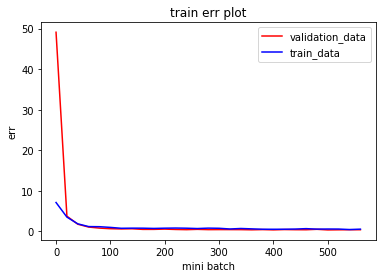

In [26]:
plot_train_err(loss_list,validation_list,batch_idx_list)


#### lets test

In [27]:
_, _, x_test, t_test = load()

print("test size: {}".format(x_test.shape[0]))
x_test=x_test.reshape((x_test.shape[0],28,28))
x_test = x_test.astype('float32') / 255.



shift_angles_test=np.random.normal(0,5,size=(x_test.shape[0]))
shift_angles_test=shift_angles_test/180
x_test_rotated=rotate_images(x_test,shift_angles_test)

#x_test=x_test.round()
#x_test_rotated=x_test_rotated.round()


test_data_tn=torch.from_numpy(x_test).float()
test_data_rotated_tn=torch.from_numpy(x_test_rotated).float()
shift_angles_test_tn=torch.from_numpy(shift_angles_test).float()
shift_angles_test_tn=shift_angles_test_tn.unsqueeze(1)


test size: 10000


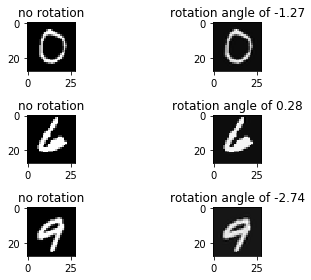

In [28]:
plot_rotated_images(x_test,x_test_rotated,shift_angles_test,pair_num_to_use=3)

In [29]:
angles_predicted_test=get_prediction(test_data_tn,test_data_rotated_tn,model)
avg_angle_err_test=angle_loss_abs(shift_angles_test_tn, angles_predicted_test,return_type="mean")
print("total avg err is: {}".format(avg_angle_err_test.data.numpy()))

total avg err is: 0.4673120379447937


#### lets analyze the results a bit

In [30]:
test_dict={}
test_dict["true_angle"]=shift_angles_test*180
test_dict["predicted_angle"]=(angles_predicted_test.data.numpy()).reshape(angles_predicted_test.shape[0])*180
test_dict["tag"]=t_test
err_vec=angle_loss_abs(shift_angles_test_tn, angles_predicted_test,return_type="full")
test_dict["err"]=(err_vec.data.numpy()).reshape(err_vec.shape[0])
test_res_df=pd.DataFrame(test_dict)
col_order=["tag","true_angle","predicted_angle","err"]
test_res_df=test_res_df[col_order]

res_summery=test_res_df['err'].groupby(test_res_df['tag']).apply(get_stats).unstack()
col_order=["count","mean_err","median_err","max_err","std_err"]
res_summery=res_summery[col_order].sort_values(by="mean_err")
res_summery

,count,mean_err,median_err,max_err,std_err
tag,,,,,
1,1135.0,0.364330,0.000549,4.868317,0.464536
7,1028.0,0.405977,0.000549,5.336029,0.551851
4,982.0,0.409358,0.000046,5.591156,0.593094
8,974.0,0.419875,0.001495,5.433136,0.557620
6,958.0,0.445474,0.000992,6.904526,0.614558
3,1010.0,0.463480,0.000015,5.931091,0.639035
5,892.0,0.469623,0.000214,6.172211,0.571828
9,1009.0,0.503223,0.000198,4.308151,0.608107
2,1032.0,0.525710,0.000656,4.512375,0.642898


## Second approch, Siamese network:

#### I also tried to use siamese network however it did not seems to work properly. The concept of siamese network is that the net is made of two parts the first is feature extractor. We have each image going threw it separately then both outputs are joined together, pass threw the upper part of the network and compared.  